# HW_2_Javier_Gilabert_Sabater
## Análisis Predictivo

In [555]:
import warnings
warnings.filterwarnings('ignore')

In [556]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [557]:
# Read Data
df = pd.read_csv('StackOverflow.csv')
df.head()

,month,nltk,spacy,stanford-nlp,python,r,numpy,scipy,matlab,machine-learning,...,Plato,Sympy,Flair,stanford-nlp.1,pyqt,Nolearn,Lasagne,OCR,Apache-spark-mlib,azure-virtual-machine
0,09-Jan,0,0,0,631,8,6,2,19,8,...,0,1,0,0,5,0,0,5,0,0
1,09-Feb,1,0,0,633,9,7,3,27,4,...,0,0,0,0,5,0,0,11,0,0
2,09-Mar,0,0,0,766,4,4,2,24,3,...,0,0,0,0,7,0,0,2,0,0
3,09-Apr,0,0,0,768,12,6,3,32,10,...,0,0,0,0,11,0,0,5,0,0
4,09-May,1,0,0,1003,2,7,2,42,7,...,0,0,0,0,10,0,0,3,0,0


## 1. - Analizar los datos de MATLAB, entre otros análisis, se debe graficar la serie, estudiar la estacionalidad y la estacionariedad.

In [558]:
df_matlab  = pd.DataFrame()
df_matlab['date'] = df['month']
df_matlab['matlab'] = df['matlab']
df_matlab

,date,matlab
0,09-Jan,19
1,09-Feb,27
2,09-Mar,24
3,09-Apr,32
4,09-May,42
...,...,...
127,19-Aug,371
128,19-Sep,362
129,19-Oct,523
130,19-Nov,479


In [559]:
df_matlab['date'] = pd.to_datetime(df_matlab['date'], format='%y-%b')
df_matlab = df_matlab.set_index('date')
df_matlab

,matlab
date,
2009-01-01,19
2009-02-01,27
2009-03-01,24
2009-04-01,32
2009-05-01,42
...,...
2019-08-01,371
2019-09-01,362
2019-10-01,523


In [560]:
df_matlab_2 = df_matlab.resample("m").last()

<Axes: xlabel='date'>

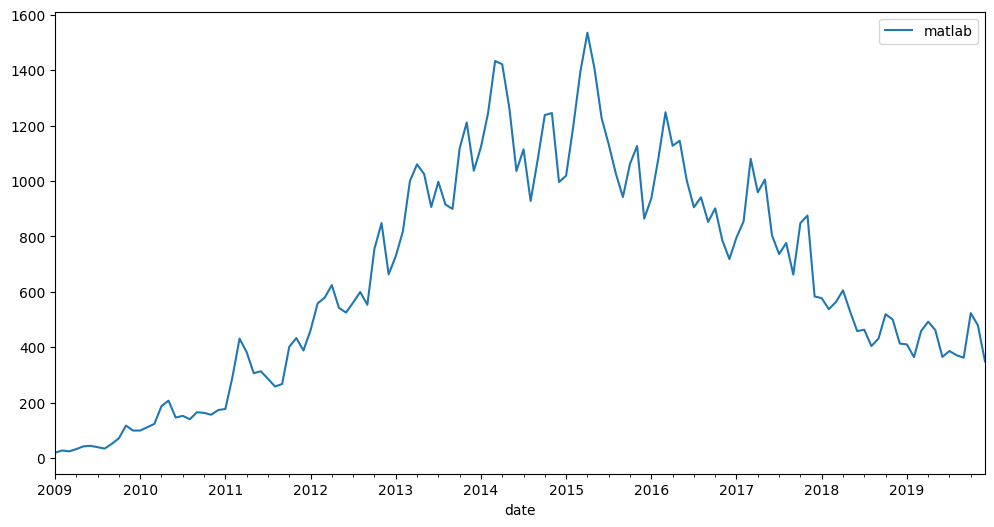

In [561]:
plt.rcParams["figure.figsize"] = (12,6)
df_matlab.plot()

## Estacionalidad

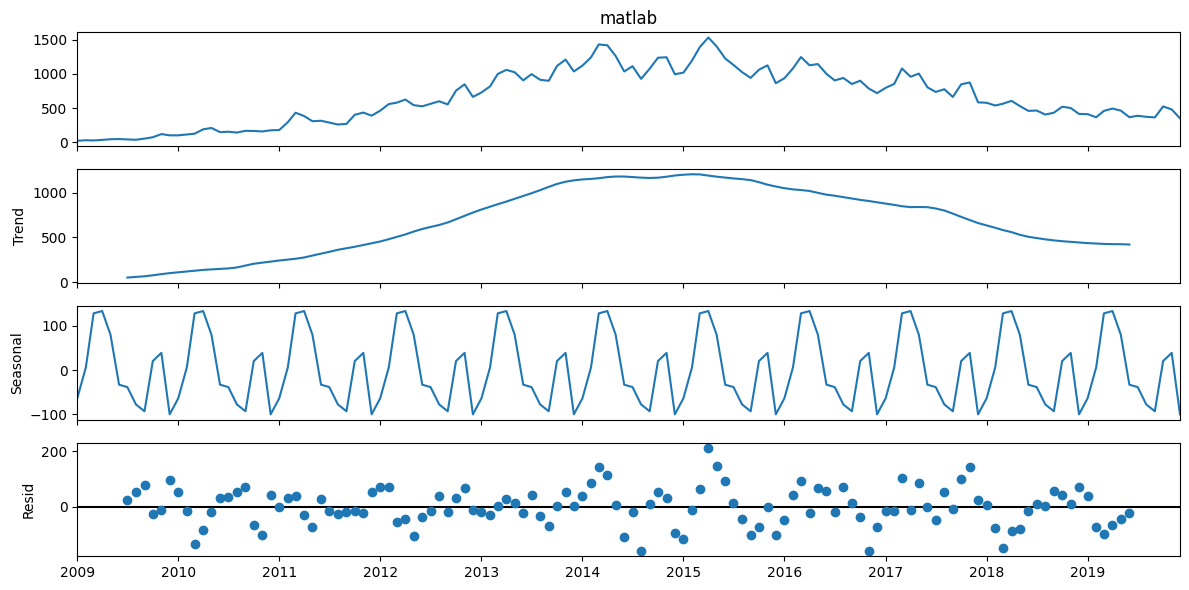

In [562]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_matlab['matlab'], model='additive', period=12)
result.plot()
plt.show()


Text(0.5, 1.0, 'Comportamiento Estacional')

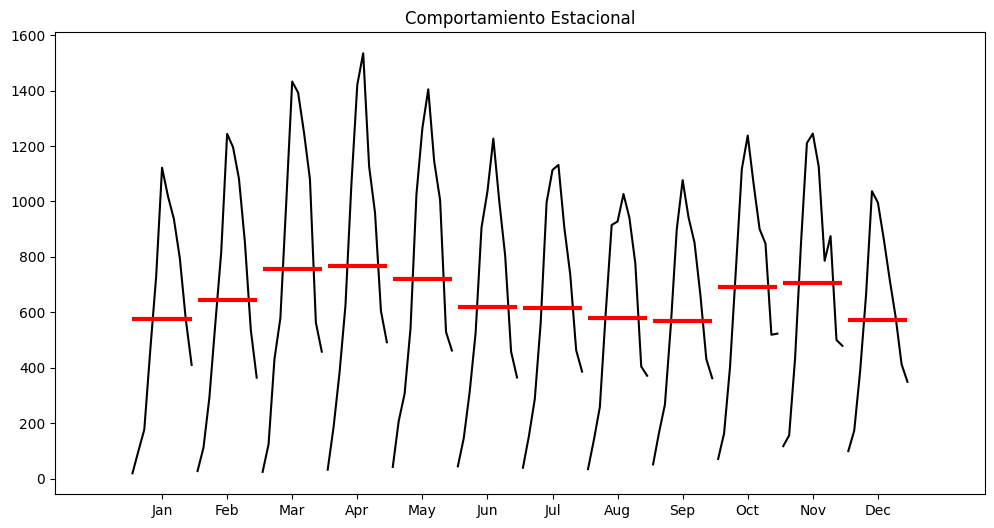

In [563]:
import statsmodels.api as sm
ax = plt.gca()
sm.graphics.tsa.month_plot(df_matlab['matlab'],ax=ax)
ax.set_title('Comportamiento Estacional')

## Estacionariedad

In [564]:
# Log Transformer Function
from sktime.transformations.series.boxcox import LogTransformer

In [565]:
# Apply Log Transformer

transformer = LogTransformer()
log_matlab= transformer.fit_transform(df_matlab)
log_matlab.tail()

,matlab
date,
2019-08-01,5.916202
2019-09-01,5.891644
2019-10-01,6.259581
2019-11-01,6.171701
2019-12-01,5.855072


Text(0.5, 1.0, 'Preguntas sobre matlab: Transformación LOG')

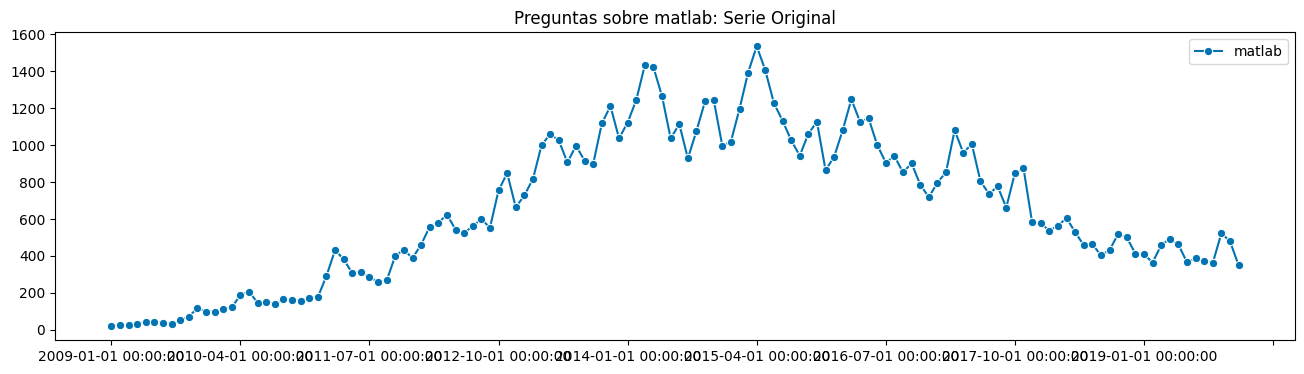

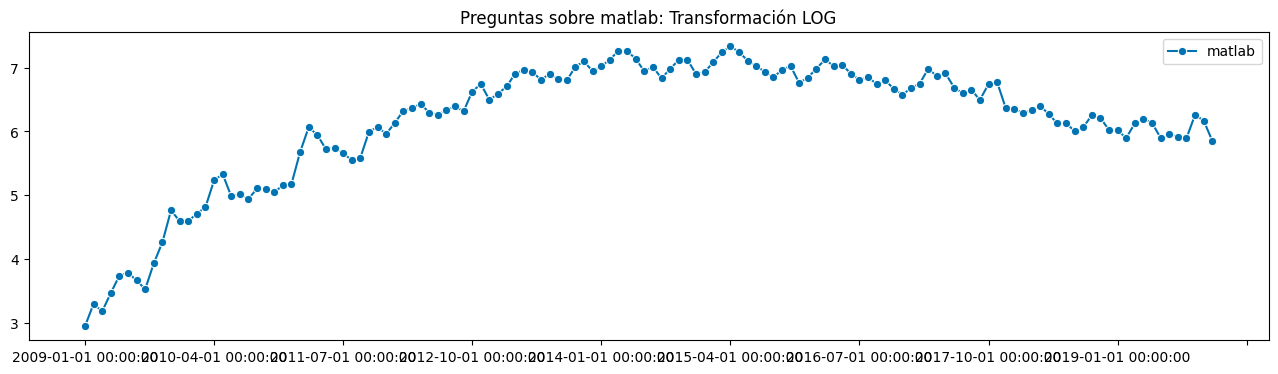

In [566]:
# Plot Log Data
#ax = log_matlab.plot(marker='o', linestyle='-')
#ax.set_ylabel('Preguntas sobre matlab')
#ax.set_title('Preguntas sobre matlab: Transformación LOG')
from sktime.utils.plotting import plot_series
fig, ax =plot_series(df_matlab, labels=["matlab"])
ax.set_title('Preguntas sobre matlab: Serie Original')
fig, ax =plot_series(log_matlab, labels=["matlab"])
ax.set_title('Preguntas sobre matlab: Transformación LOG')

## 2. - Se debe separa la muestra en tres partes entrenamiento, validación(12 meses) y test (6 meses). Cuando no sea necesaria la validación la muestra de test debe ser de 6 meses.

In [567]:

data_train = df_matlab_2['2009-01-01':'2019-01-01']
data_valid = df_matlab_2['2019-01-01':'2019-12-31']
data_test = df_matlab_2['2019-07-01':'2019-12-31']


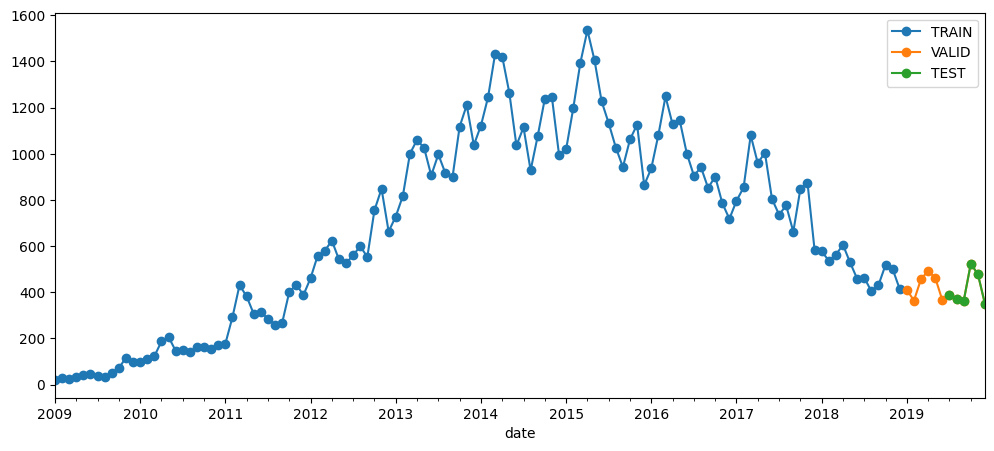

In [568]:
data_train['matlab'].plot(legend=True,label='TRAIN',marker='o')
data_valid['matlab'].plot(legend=True,label='VALID',figsize=(12,5),marker='o');
data_test['matlab'].plot(legend=True,label='TEST',figsize=(12,5),marker='o');

## ETS

In [569]:
from sktime.forecasting.ets import AutoETS

In [570]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 13)

# step 3: specifying the forecasting algorithm
matlab_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)


In [571]:
matlab_auto_model.fit(data_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [572]:
# step 5: querying predictions
matlab_ets_pred = matlab_auto_model.predict(fh)
print(matlab_ets_pred)

                matlab
2019-01-31  412.582927
2019-02-28  449.855996
2019-03-31  476.341624
2019-04-30  446.815620
2019-05-31  445.681164
2019-06-30  485.234814
2019-07-31  513.081058
2019-08-31  480.625831
2019-09-30  478.779402
2019-10-31  520.613633
2019-11-30  549.820492
2019-12-31  514.436042


In [573]:
matlab_pred_ints = matlab_auto_model.predict_interval(fh, coverage=0.9)

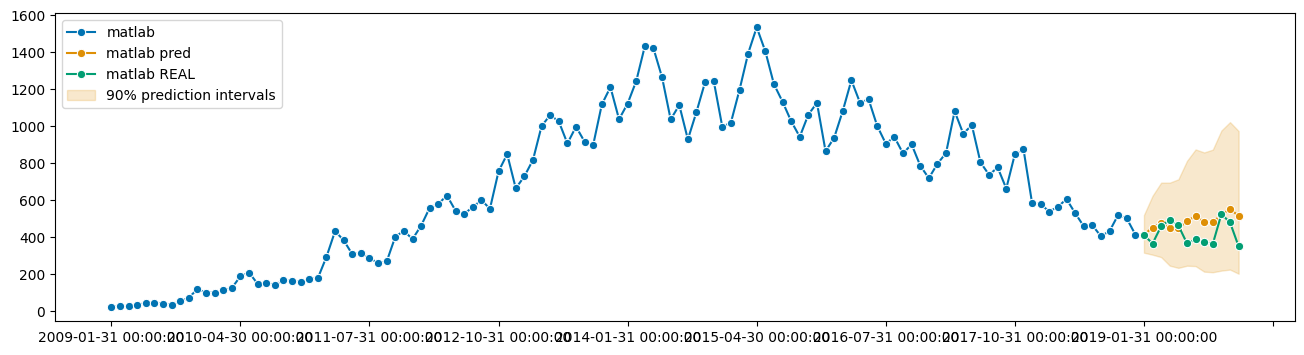

In [574]:
fig, ax = plot_series(data_train, matlab_ets_pred, data_valid, labels=["matlab", "matlab pred", "matlab REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    matlab_pred_ints[(0, 0.9, 'lower')],
    matlab_pred_ints[(0, 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')

In [575]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
mean_absolute_percentage_error(data_valid, matlab_ets_pred)

0.19271135425241856

## ARIMA

In [576]:
from sktime.forecasting.arima import AutoARIMA

In [579]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True, trace = True)
forecaster.fit(data_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=1435.455, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1449.561, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1451.852, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1451.706, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1447.679, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=1433.627, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=1431.433, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=1446.236, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=1444.958, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[4] intercept   : AIC=1433.505, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[4] intercept   : AIC=1434.781, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1450.474, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[4] intercept   : AIC=1447.825, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[4] intercept   : 

AutoARIMA(sp=4, suppress_warnings=True, trace=True)

In [580]:
matlab_arima_pred = forecaster.predict(fh)
matlab_arima_pred

,matlab
2019-01-31,359.084766
2019-02-28,364.778717
2019-03-31,427.511073
2019-04-30,489.931060
2019-05-31,495.823093
2019-06-30,444.116887
2019-07-31,389.113197
2019-08-31,387.491287
2019-09-30,443.802037
2019-10-31,506.853212


In [581]:
mean_absolute_percentage_error(data_valid, matlab_arima_pred)

0.10342851009858785

## 4Theta